# Intro
In this notebook we'll develop a LSTM for predictive maintenance on FD004 to predict the Remaining Useful Life (RUL) of the engines. FD004 is characterized by the engines running on different operating conditions and developing one of two possible faults.(see metadata below). You can find a full explanation of the code in my accompanying blogpost [here](https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3?sk=b2bd1590168a6eaab5d13857807afbda)  

Data Set: FD004  
Train trjectories: 248  
Test trajectories: 249  
Conditions: SIX  
Fault Modes: TWO (HPC Degradation, Fan Degradation)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

# important: set random seeds to get reproducible results

Initial weights of neural networks are generated randomly. Due to this randomness results may vary, making it very difficult to judge whether the changes you make are because of this randomness or actuall improvements to model performance. Therefore we wan't to control the random initialization to allow comparing between iterations.

#### Find a more thorough explanation on getting reproducible results [here](https://towardsdatascience.com/primer-on-developing-reproducible-neural-networks-in-jupyter-notebook-2f88d23b7c8d?sk=dbb8d4efdc36aa676cb97857b946c5ca)

In [3]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
dir_path = '../CMAPSSData/'
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [5]:
print(train.shape)
train.head()

(61249, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    42.0049     0.8400      100.0  445.00  549.68   
1        1            2    20.0020     0.7002      100.0  491.19  606.07   
2        1            3    42.0038     0.8409      100.0  445.00  548.95   
3        1            4    42.0000     0.8400      100.0  445.00  548.70   
4        1            5    25.0063     0.6207       60.0  462.54  536.10   

       s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  s_17  \
0  1343.43  1112.93  3.91  ...  129.78  2387.99  8074.83   9.3335  0.02   330   
1  1477.61  1237.50  9.35  ...  312.59  2387.73  8046.13   9.1913  0.02   361   
2  1343.12  1117.05  3.91  ...  129.62  2387.97  8066.62   9.4007  0.02   329   
3  1341.24  1118.03  3.91  ...  129.80  2388.02  8076.05   9.3369  0.02   328   
4  1255.23  1033.59  7.05  ...  164.11  2028.08  7865.80  10.8366  0.02   305   

   s_18    s_19   s_20     s_21  
0  2212  100.00  10.62   6.3670  
1  2324  100.00  24.37  14.6552  
2  2212  100.00  10.48   6.4213  
3  2212  100.00  10.54   6.4176  
4  1915   84.93  14.03   8.6754  

[5 rows x 26 columns]

In [6]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  320
1        1            2  319
2        1            3  318
3        1            4  317
4        1            5  316

# Baseline model

In [7]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() # get last row of each engine

In [8]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [9]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.437942286411733, R2:0.722073897506166
test set RMSE:34.5937359113724, R2:0.5974472412018739


# Plotting

In [10]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [11]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.27462144 -0.32737159 -0.92936463  1.47860752 -0.92936463 -0.92936463
  0.27462144  0.87661448 -0.32737159  0.87661448 -2.73534374  1.47860752
 -0.92936463  0.87661448 -1.53135767  0.87661448 -0.92936463  0.87661448
 -0.92936463 -0.32737159 -0.92936463  1.47860752  

In [12]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

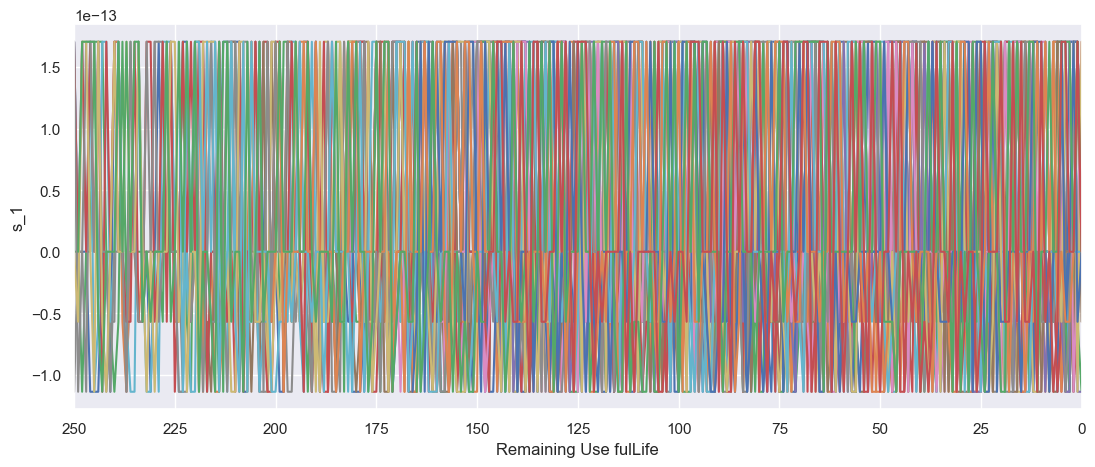

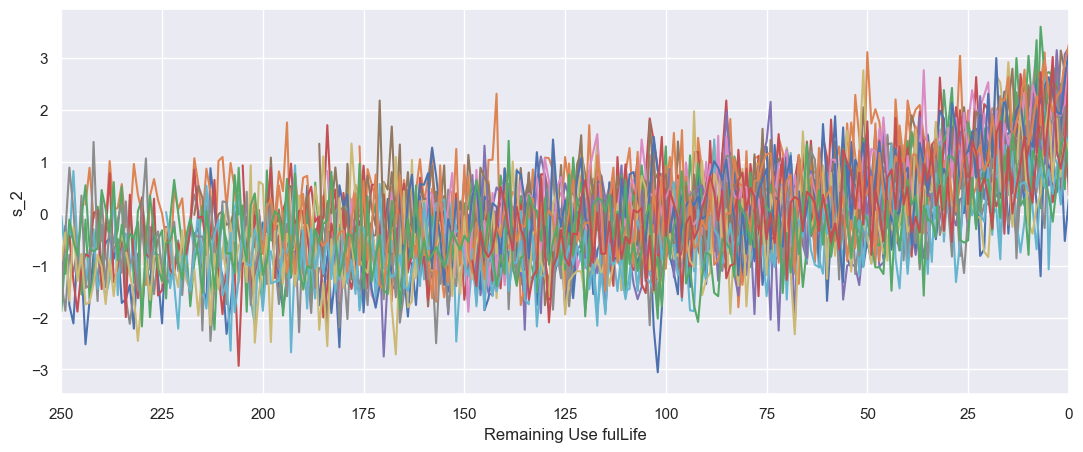

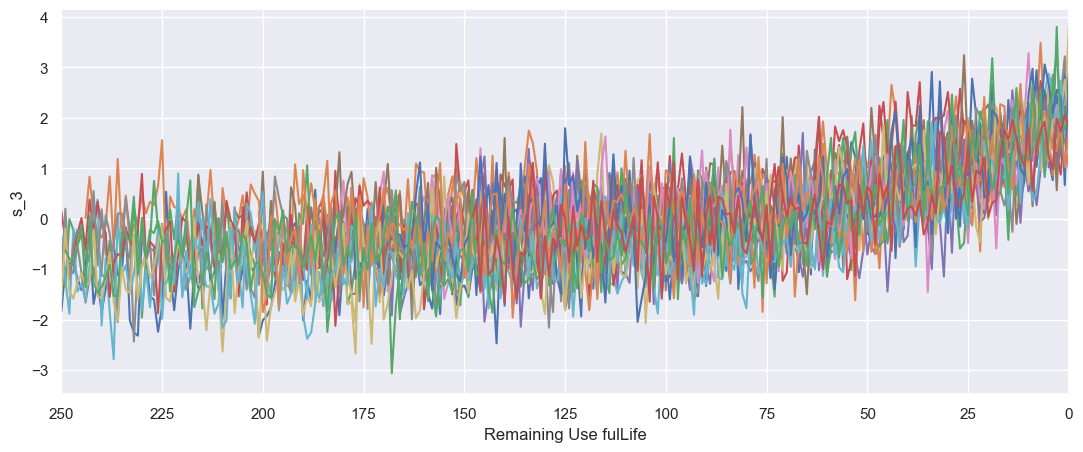

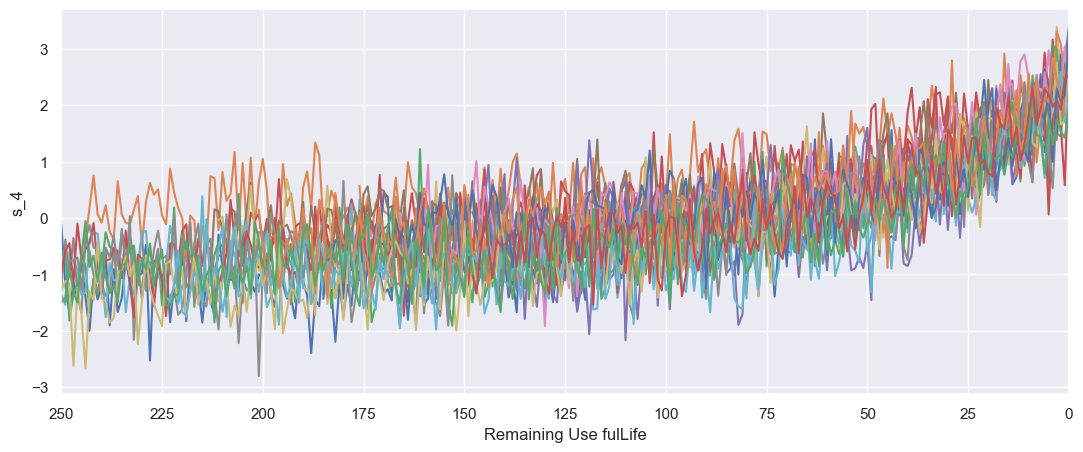

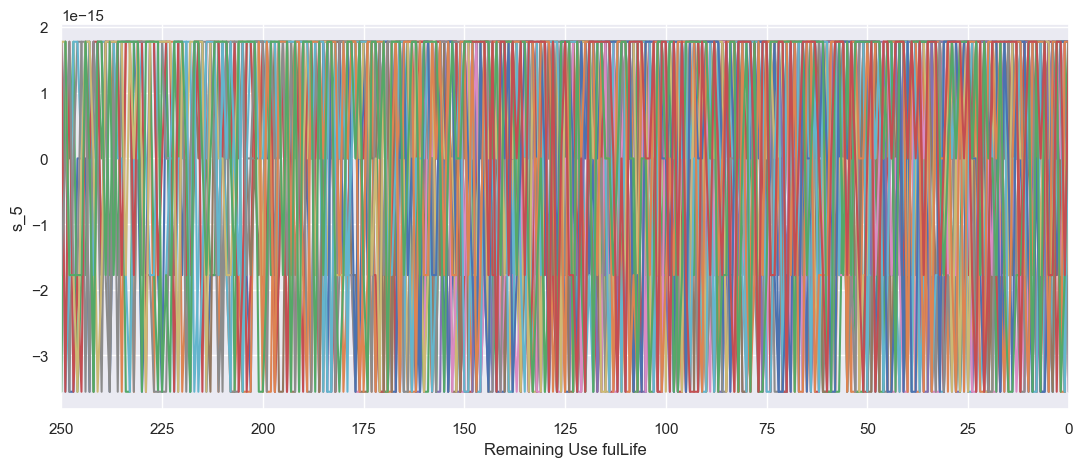

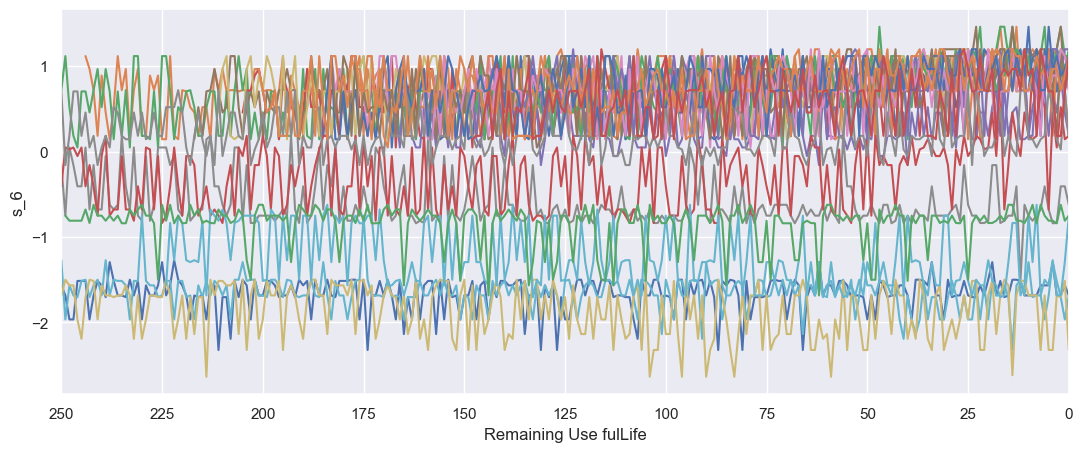

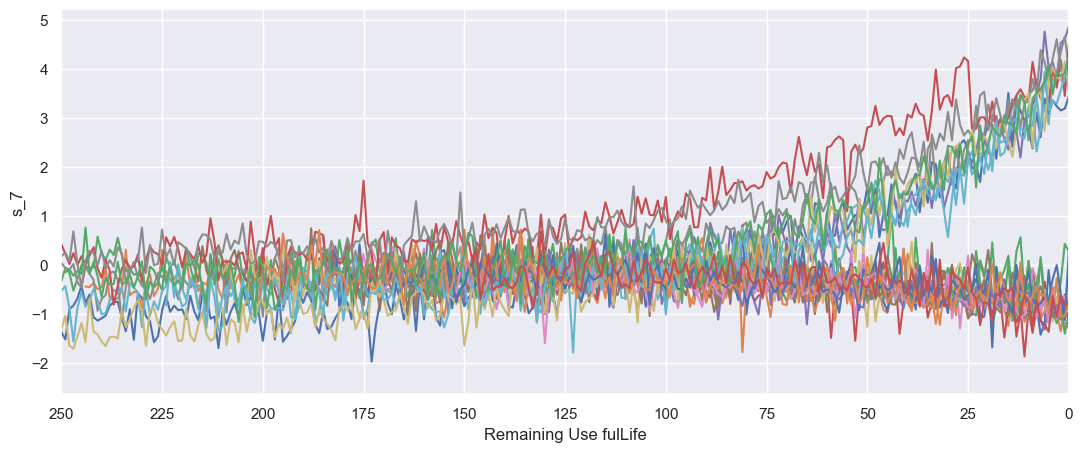

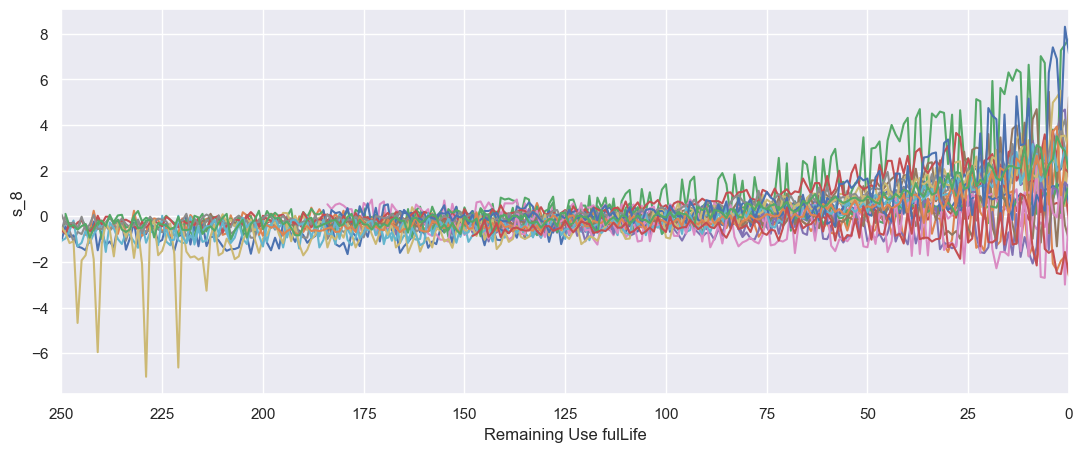

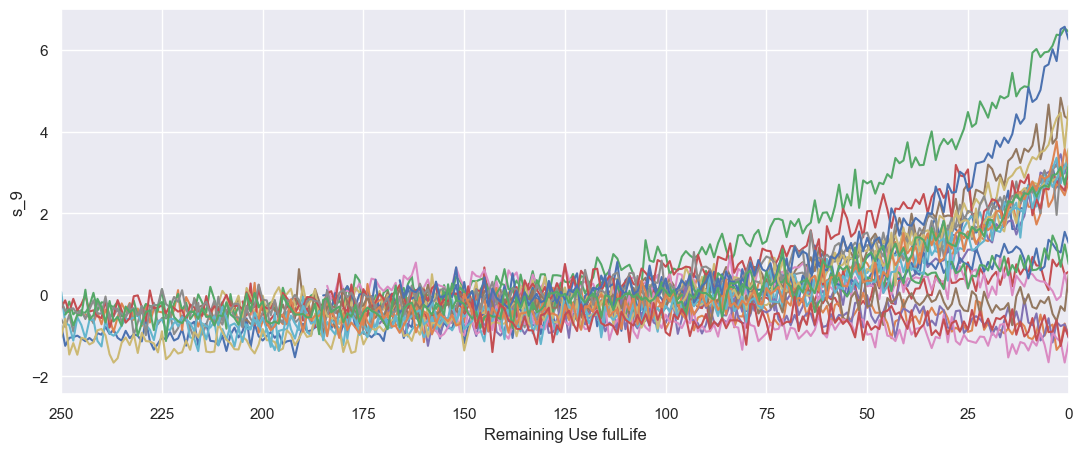

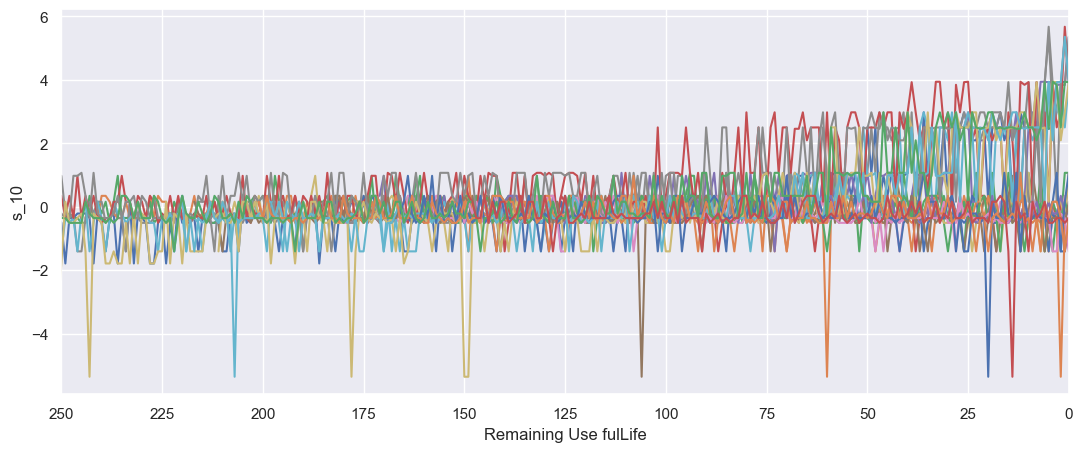

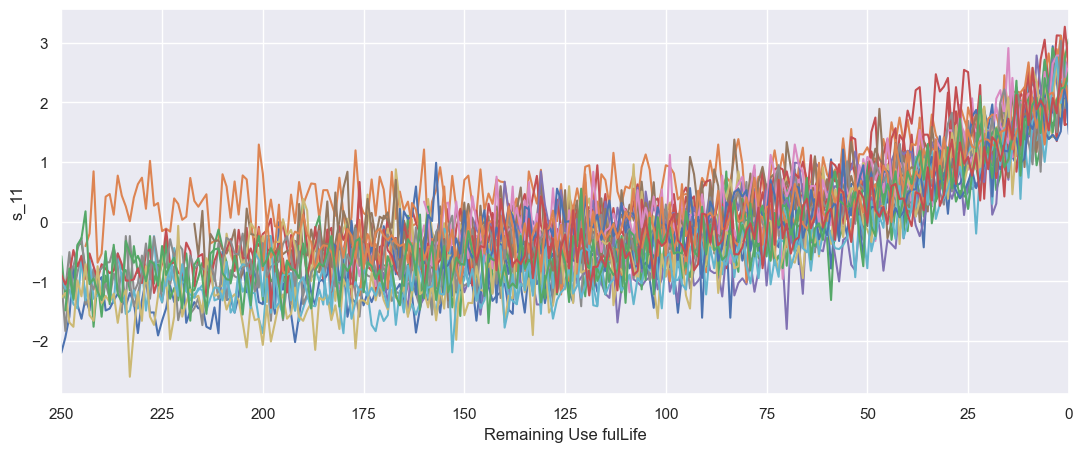

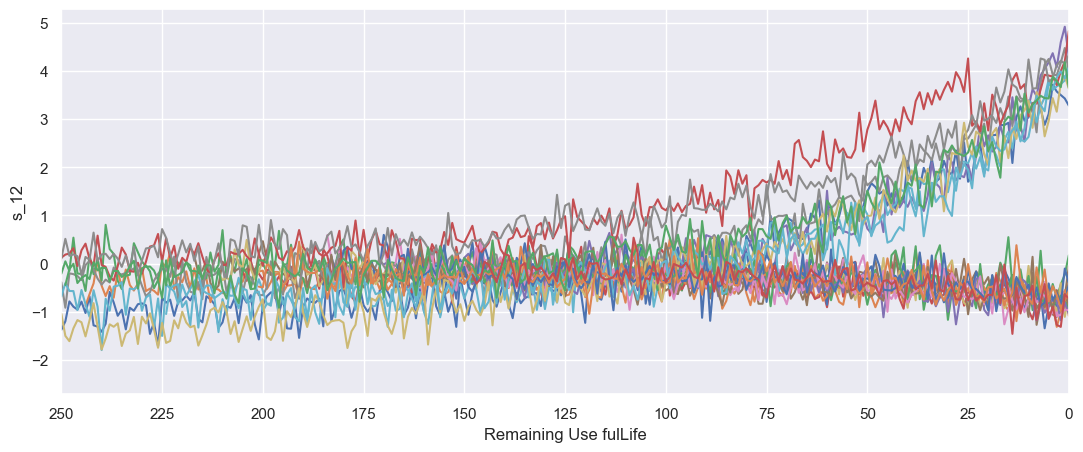

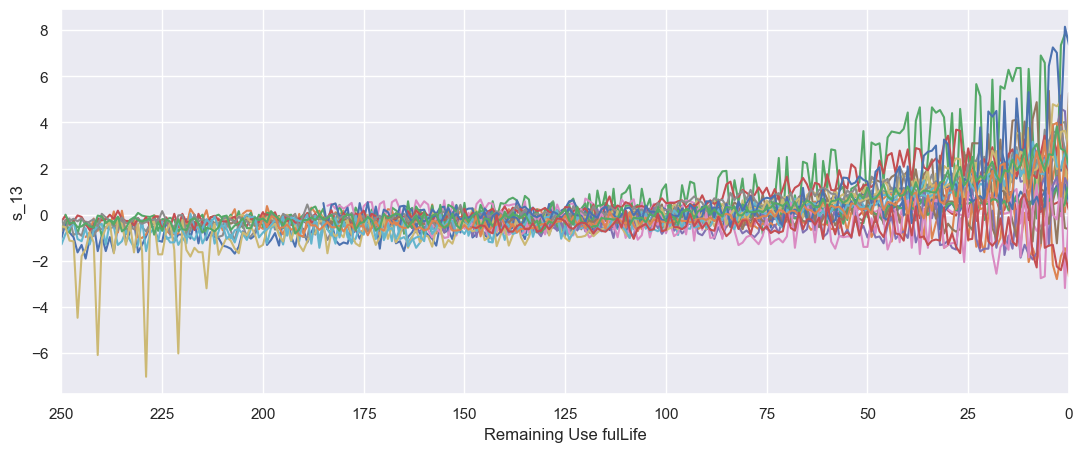

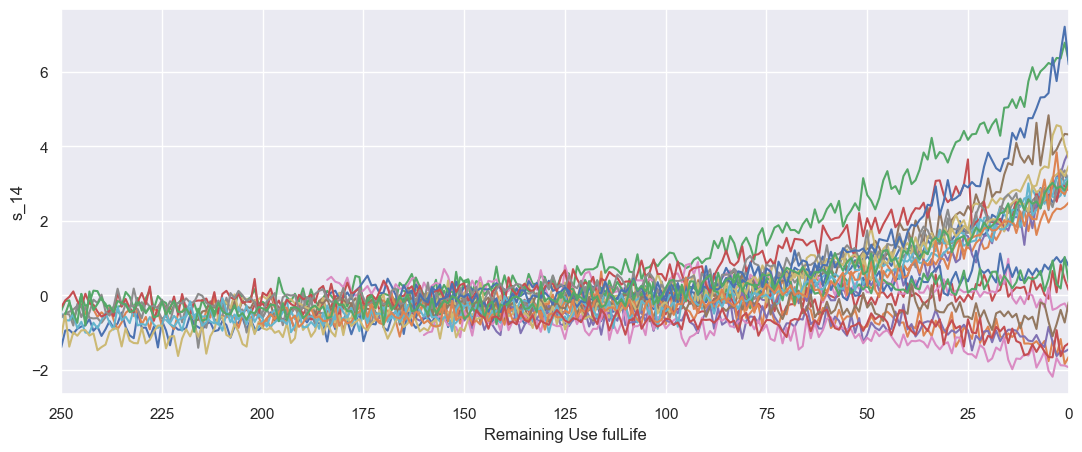

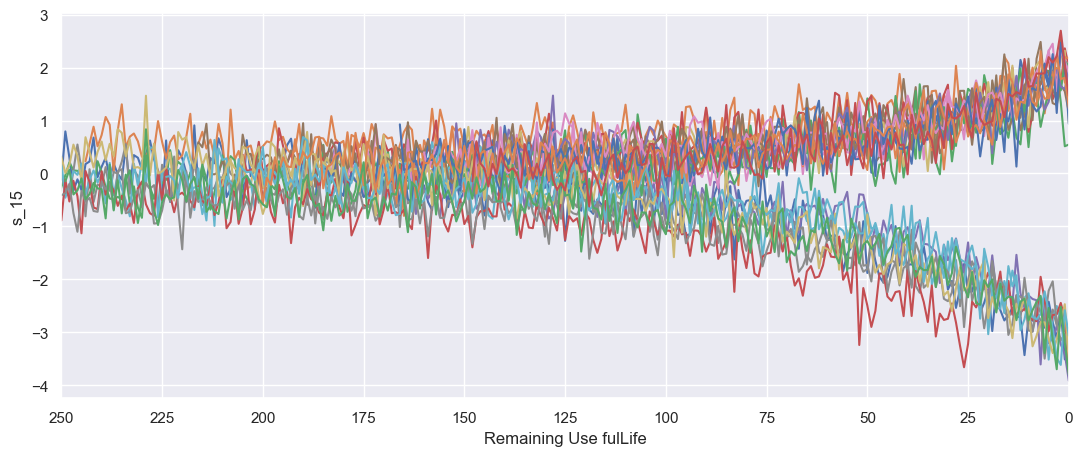

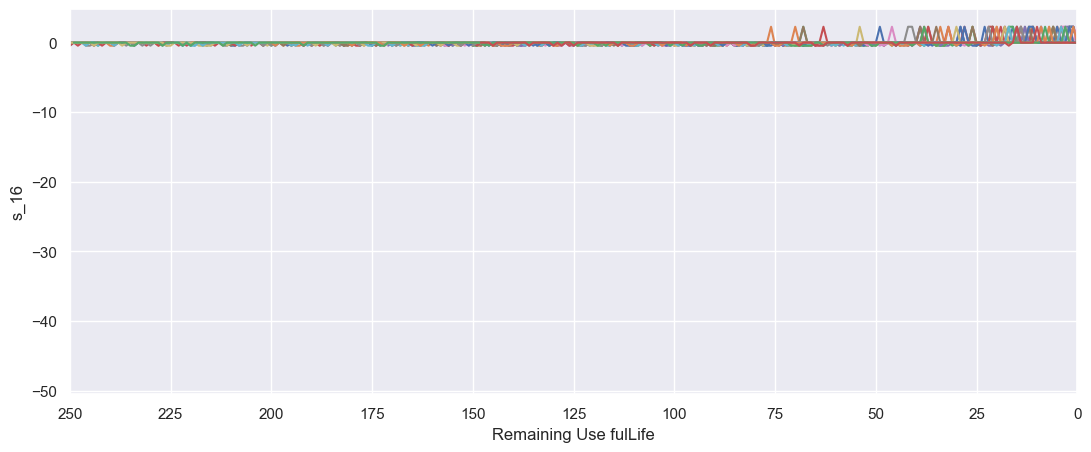

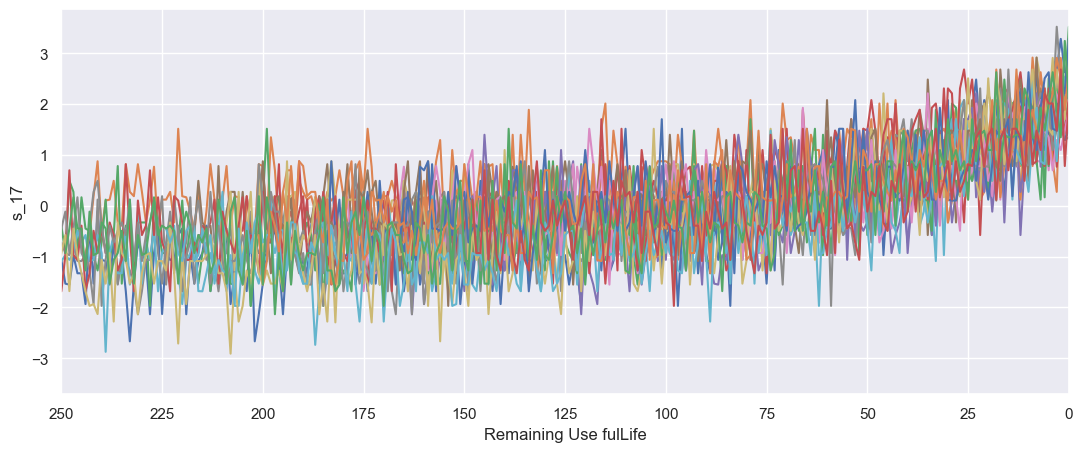

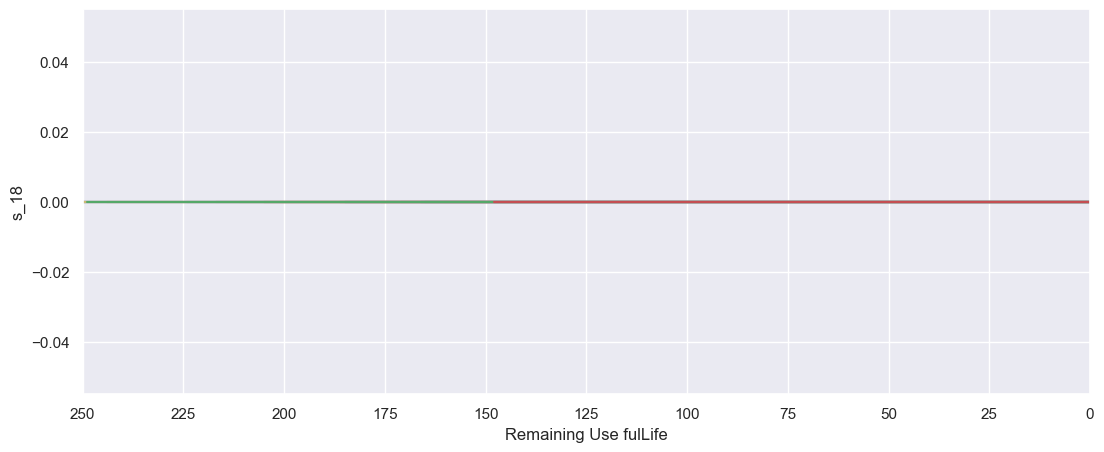

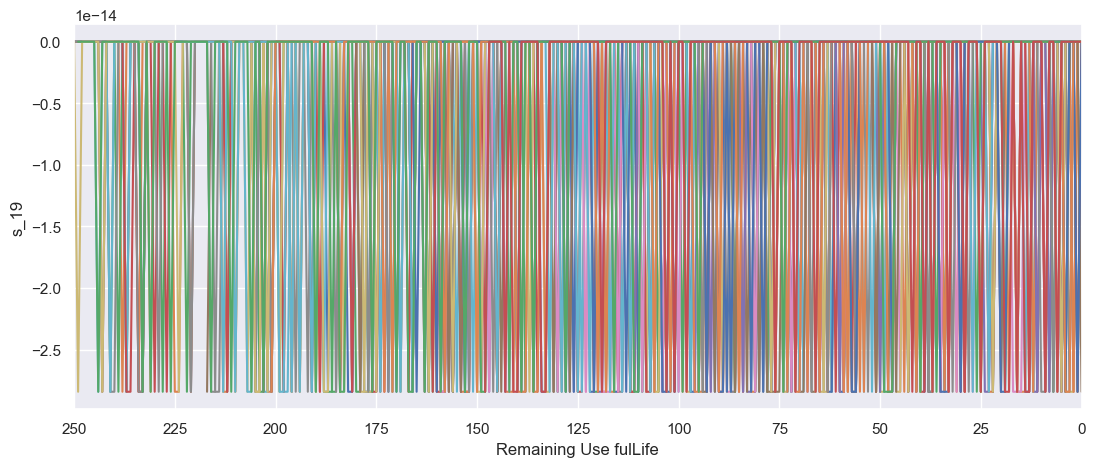

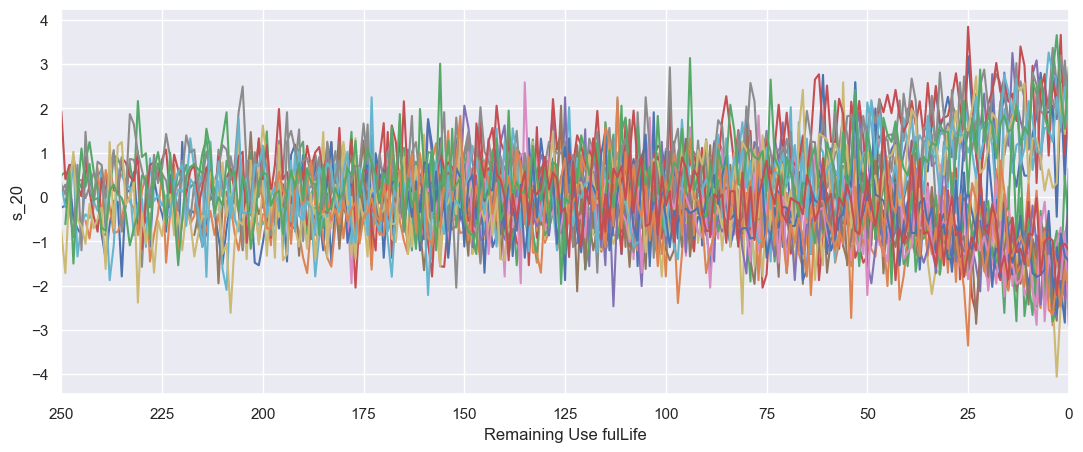

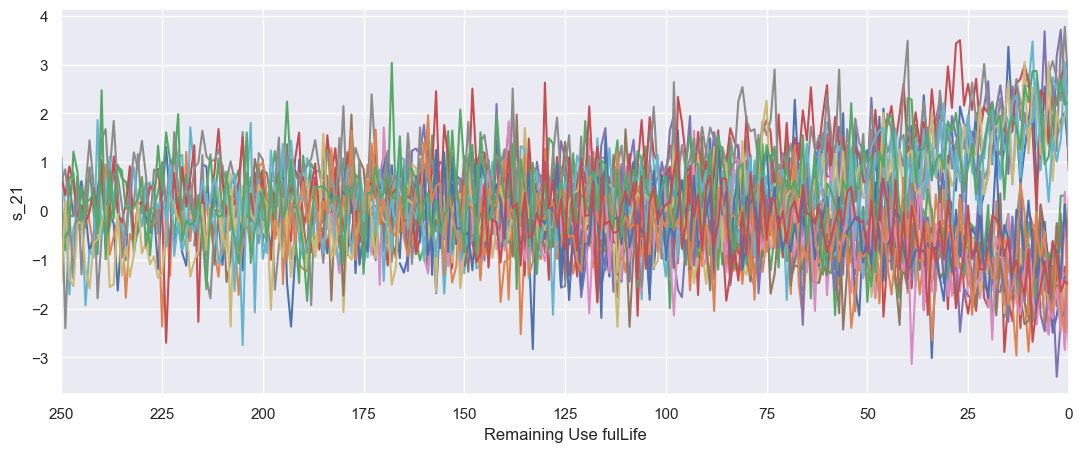

In [13]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

Note, useable sensors seem to be ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'], however sensors ['s_8', 's_9', 's_13', 's_14'] might confuse the model as they don't seem to distinguish between the two fault modes very well. Something we'll have to test during model development

In [14]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# Data preparation
We can reuse some of the functions from last time, like exponential_smoothing and train_val_group_split

In [32]:
def exponential_smoothing(df, remaining_sensors, n_samples=0, alpha=0.4):
        df = df.copy()
        # Create an empty DataFrame to store the smoothed values
        smoothed_values = pd.DataFrame(index=df.index, columns=remaining_sensors)
        # Group by 'unit_nr' and apply exponential smoothing to each group
        for unit_nr, group in df.groupby('unit_nr'):
            smoothed_group = group[remaining_sensors].ewm(alpha=alpha).mean()
            smoothed_values.loc[group.index] = smoothed_group.values
        # Assign the smoothed values back to the DataFrame
        df[remaining_sensors] = smoothed_values
        if n_samples > 0:
            mask = df.groupby('unit_nr')['unit_nr'].transform(lambda x: np.arange(len(x)) >= n_samples)
            df = df[mask]
        return df

In [16]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

## Sequences

In [17]:
d = {'unit_nr': [1]*5 + [2]*5,
     'X': [10., 10.2, 10.4, 10.6, 10.8, 20., 20.2, 20.4, 20.6, 20.8],
     'y': [1.4, 1.4, 1.3, 1.2, 1.1, 2.4, 2.4, 2.3, 2.2, 2.1]}
example_df = pd.DataFrame(data=d)
example_df

unit_nr     X    y
0        1  10.0  1.4
1        1  10.2  1.4
2        1  10.4  1.3
3        1  10.6  1.2
4        1  10.8  1.1
5        2  20.0  2.4
6        2  20.2  2.4
7        2  20.4  2.3
8        2  20.6  2.2
9        2  20.8  2.1

code for generating sequences is based on code in Microsoft Azure's github repository [https://github.com/Azure/lstms_for_predictive_maintenance]. However, considerable changes have been made.  
See example_df above, the traditional generator would create a sequence [10., 10.2, 10.4, 10.6] to predict [1.1], where I want the sequence [10., 10.2, 10.4, 10.6, 10.8] to predict [1.1]. The latter is in line with previous implementations throughout the series, plus we can add that tiny bit more information to perform our predictions.  
The original code would not consider engines if the number of records for that engine was lower than the sequence that's being generated, effectively removing part of the test set. I do want to include all test engines, therefore I've implemented padding. see further down below. 

In [18]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]


In [19]:
gen = gen_train_data(example_df[example_df['unit_nr']==1], sequence_length=4, columns=['X'])
list(gen)

[array([[10. ],
        [10.2],
        [10.4],
        [10.6]]),
 array([[10.2],
        [10.4],
        [10.6],
        [10.8]])]

In [20]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [21]:
data_array = gen_data_wrapper(example_df, sequence_length=4, columns=['X'])
data_array

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]],

       [[20.2],
        [20.4],
        [20.6],
        [20.8]]], dtype=float32)

For the labels we'll do something similar

In [22]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [23]:
label = gen_labels(example_df[example_df['unit_nr']==1], sequence_length=4, label=['y'])
label

array([[1.2],
       [1.1]])

In [24]:
label_array = gen_label_wrapper(example_df, sequence_length=4, label=['y'])
label_array

array([[1.2],
       [1.1],
       [2.2],
       [2.1]], dtype=float32)

In [25]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b
a

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

In [26]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

In [27]:
# notice the masked value I passed is a float, 
# it should be the same datatype as the data you're working with
gen = (list(gen_test_data(example_df[example_df['unit_nr']==unit_nr], sequence_length=6, columns=['X'], mask_value=-99.))
           for unit_nr in example_df['unit_nr'].unique())
next(gen)

[array([[-99. ],
        [ 10. ],
        [ 10.2],
        [ 10.4],
        [ 10.6],
        [ 10.8]])]

# LSTM

In [28]:
# # test to see if results are better on the first initialization
# remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 
#        's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
# drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [33]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/559617802.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compati

In [38]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

In [39]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.weights.h5')

In [42]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
#model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=50,
                   batch_size=32)

Epoch 1/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 243.8571 - val_loss: 371.0152
Epoch 2/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 224.8819 - val_loss: 367.8623
Epoch 3/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 215.3619 - val_loss: 364.0249
Epoch 4/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 209.1370 - val_loss: 361.5464
Epoch 5/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 204.5622 - val_loss: 359.1430
Epoch 6/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 200.6382 - val_loss: 358.5960
Epoch 7/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 197.5954 - val_loss: 354.3643
Epoch 8/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 194.3326 - val_loss: 350.7523
Epoch 9/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 191.6190 - val_loss: 349.8076
Epoch 10/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 189.0744 - val_loss: 348.8221
Epoch 11/50
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 186.3125 - val_

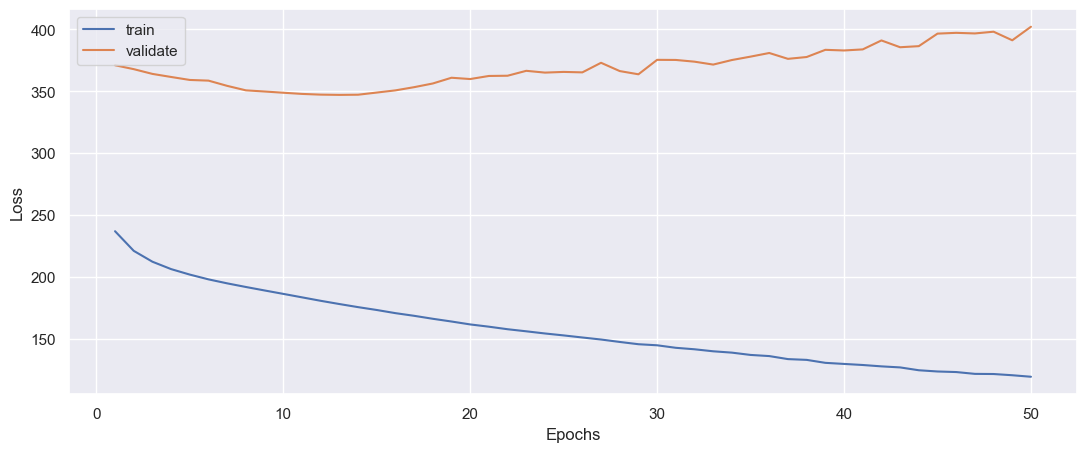

In [43]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [44]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step
train set RMSE:13.194723129272461, R2:0.8975507020950317
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
test set RMSE:27.534347631049556, R2:0.7449780702590942


With an RMSE of 29.043 the current LSTM is already quite an improvement over the baseline model, about (34.594 - 29.043) / 34.594 * 100 = 16.04%  
There are two more things to check before hyperparameter tuning;  
    - (I) model performance without sensors 8, 9, 13 and 14 and  
    - (II) validation loss behavior when running more epochs

## try with less sensors

In [45]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 
       's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [46]:
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_

In [47]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

/Users/mohamedmentis/Dropbox/Mac (2)/Documents/Mentis/Development/Python/Predictive_Maintenance/predictive-maintenance-demo/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('fewer_sensors_lstm.weights.h5')

In [49]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('fewer_sensors_lstm.weights.h5')

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=5,
                    batch_size=32)

Epoch 1/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7087.0210 - val_loss: 3127.4119
Epoch 2/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2526.5437 - val_loss: 1137.3571
Epoch 3/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 897.3964 - val_loss: 523.6761
Epoch 4/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 406.7241 - val_loss: 393.9891
Epoch 5/5
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 288.1784 - val_loss: 369.8179


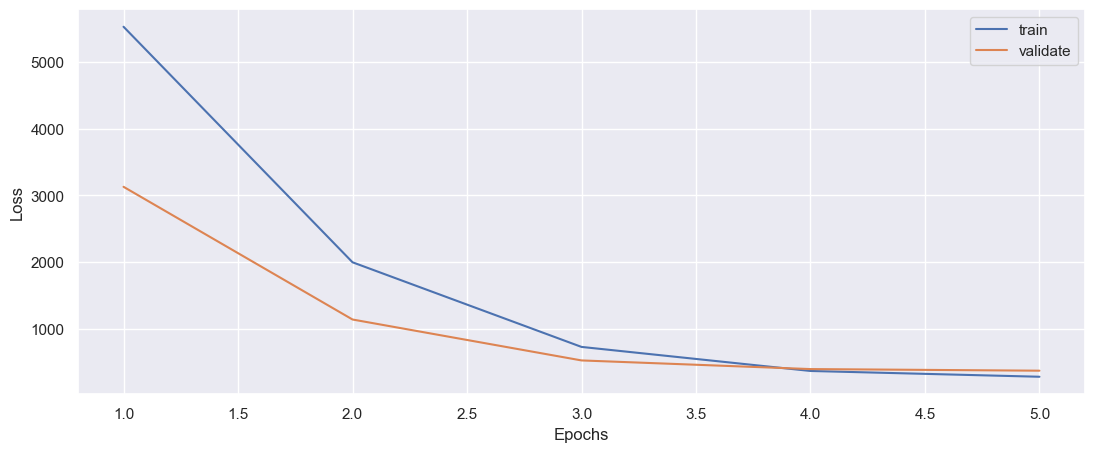

In [50]:
plot_loss(history)

In [51]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 2s 930us/step
train set RMSE:16.700265884399414, R2:0.8358824253082275
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
test set RMSE:29.40064819794351, R2:0.7092353105545044


Validation loss has increased a bit, although it may be difficult to fully account this change to the removal of the sensors compared to the re-initialized model weights. To be sure we'll include both sets of sensors in the hyperparameter tuning approach.   
Like last time, let's train once with considerably increased epochs to view how the validation loss behaves

In [54]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('fewer_sensors_lstm.weights.h5')

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7087.0210 - val_loss: 3127.4119
Epoch 2/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2526.5437 - val_loss: 1137.3571
Epoch 3/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 897.3964 - val_loss: 523.6761
Epoch 4/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 406.7241 - val_loss: 393.9891
Epoch 5/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 288.1784 - val_loss: 369.8179
Epoch 6/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 262.9434 - val_loss: 363.1064
Epoch 7/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 253.8228 - val_loss: 362.2296
Epoch 8/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 248.2255 - val_loss: 361.3140
Epoch 9/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 243.8317 - val_loss: 361.1125
Epoch 10/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 239.5297 - val_loss: 361.7575
Epoch 11/20
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 235.7926 - v

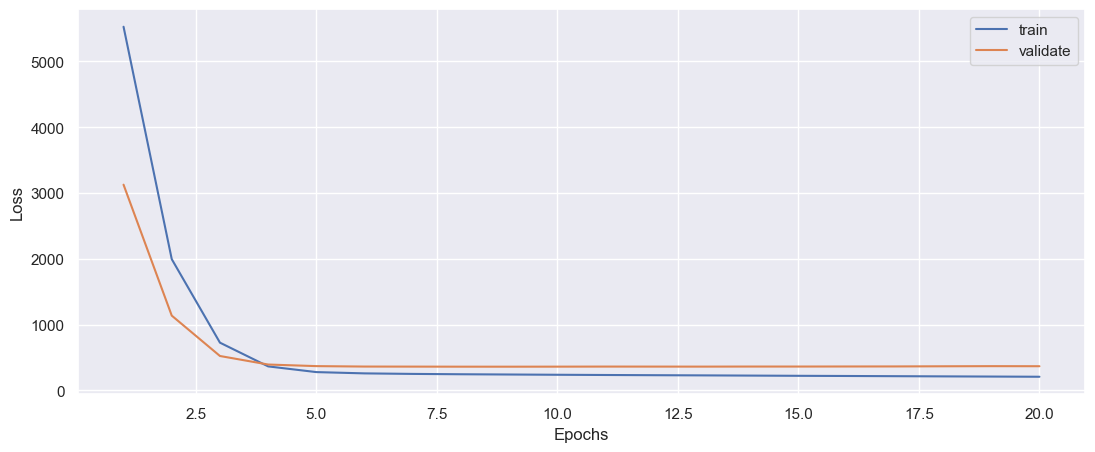

In [55]:
plot_loss(history)

In [56]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 2s 906us/step
train set RMSE:15.46369457244873, R2:0.8592867851257324
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
test set RMSE:29.507535881322344, R2:0.7071172595024109


The validation loss seems quite stable, however the models starts to overfit slightly after 15 epochs. We can play around with different epochs, but shouldn't push it too far.

# Hyperparameter tuning
parameters to tune:
    - alpha, filter strength
    - sequence_length
    - epochs
    - number of layers
    - nodes per layer
    - dropout
    - optimizer, learning rate (I choose to not tune this parameter)
    - activation function
    - batch size
    - included sensors

In [57]:
# I know lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)  

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128, 256]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'],
               ['s_2', 's_3', 's_4', 's_7', 's_11', 's_12', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

100352

In [58]:
train['RUL'].clip(upper=125, inplace=True)

def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim, X_test_interim

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/673651714.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)


In [59]:
# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [60]:
# random grid search takes significant time, set iterations to a higher number if you truly want to tune parameters
ITERATIONS = 1

In [62]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 
                                'sequence_length', 'sensor_length'])  

weights_file = 'lstm_hyper_parameter.weights.h5'


for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
    
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)
    
    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

iteration  1


/Users/mohamedmentis/Dropbox/Mac (2)/Documents/Mentis/Development/Python/Predictive_Maintenance/predictive-maintenance-demo/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587

KeyboardInterrupt: 

In [53]:
results.sort_values('MSE')

MSE    std_MSE  alpha epochs       nodes  dropout activation  \
55   202.556666  50.056461   0.10     15       [256]      0.1    sigmoid   
38   206.242305  39.779716   0.60     15    [32, 64]      0.1    sigmoid   
18   211.020928  36.028481   0.40     15        [64]      0.1       tanh   
47   212.377323  38.932341   0.10      5       [256]      0.1    sigmoid   
9    222.946994  55.546115   0.30     10   [64, 128]      0.3       tanh   
42   225.306035  50.987649   0.10     20    [32, 64]      0.4       tanh   
12   228.040716  50.631628   0.50     20       [128]      0.2       tanh   
11   231.121528  37.866211   0.50     20        [64]      0.3       tanh   
44   232.570050  53.575239   0.01     15  [128, 256]      0.1    sigmoid   
35   237.084378  35.547511   0.20     15        [64]      0.3    sigmoid   
19   239.045843  37.385994   0.60      5  [128, 256]      0.2       tanh   
45   241.176916  44.393805   0.05     20    [32, 64]      0.2       tanh   
31   247.747978  47.887341   0.30     20        [64]      0.2    sigmoid   
16   249.489350  19.675979   0.10      5  [128, 256]      0.3       tanh   
21   255.255571  32.907517   0.60     20        [32]      0.2       tanh   
22   257.469404  30.187253   0.01     10    [32, 64]      0.2       tanh   
7    266.239508  32.696072   0.60     15        [64]      0.3    sigmoid   
43   266.836674  64.593638   0.10      5  [128, 256]      0.3       tanh   
28   268.218119  75.603227   0.30     10  [128, 256]      0.1    sigmoid   
41   268.435983  47.282438   0.50     15        [32]      0.1    sigmoid   
53   293.232215  49.788543   0.40     15   [64, 128]      0.1    sigmoid   
14   296.167974  35.884825   0.50     20    [32, 64]      0.3       tanh   
3    302.462499  48.151808   0.40     10        [64]      0.3       tanh   
49   312.573548  32.441353   0.50     15  [128, 256]      0.1    sigmoid   
13   315.285206  16.386011   0.01      5        [64]      0.2    sigmoid   
17   319.083126  26.519822   0.10      5    [32, 64]      0.3    sigmoid   
51   319.373614  33.906554   0.50     15       [256]      0.1    sigmoid   
0    321.771363  65.194097   0.05     15        [64]      0.2       tanh   
4    323.698217  44.388511   0.05     15    [32, 64]      0.3       tanh   
10   329.853791  37.082487   0.40     15        [32]      0.2    sigmoid   
1    330.055590  42.897535   0.50      5        [32]      0.2       tanh   
36   330.282352  46.788824   0.60      5        [32]      0.4       tanh   
50   332.328514  49.039061   0.40      5       [128]      0.2    sigmoid   
48   339.297594  38.058911   0.60     15  [128, 256]      0.2       tanh   
32   340.571868  30.298787   0.01     15        [32]      0.1    sigmoid   
40   357.305619  55.829992   0.40     15    [32, 64]      0.4    sigmoid   
23   361.126511  29.164949   0.20      5  [128, 256]      0.3       tanh   
24   362.494096  34.187760   0.60     10   [64, 128]      0.4       tanh   
2    373.876310  35.582501   0.50     20    [32, 64]      0.3       tanh   
5    375.185959  32.952867   0.50     15  [128, 256]      0.3       tanh   
54   380.037987  21.753608   0.40     15    [32, 64]      0.2       tanh   
15   380.212262  29.863014   0.40     15       [256]      0.2    sigmoid   
46   385.327937  32.151271   0.50     10   [64, 128]      0.3    sigmoid   
30   389.843707  28.973765   0.50     10       [256]      0.1    sigmoid   
20   468.919582  31.738451   0.30     20        [64]      0.2    sigmoid   
37   480.211582  39.359066   0.30     15        [32]      0.2    sigmoid   
39   564.302399  22.494077   0.30      5   [64, 128]      0.2    sigmoid   
27   747.498057  28.323923   0.05     10        [64]      0.4       tanh   
8    762.521011  21.180583   0.05     10    [32, 64]      0.2       tanh   
26   763.683665  19.481236   0.60      5   [64, 128]      0.1       tanh   
6   1386.403596  52.843390   0.20     15        [32]      0.2       tanh   
29  1727.365863  30.814490   0.01     10        [64]      0.

In [ ]:
# 10 runs took about 6h --> so 60 runs will take about 36h on my commodity laptop
# best 
# mse=237.83, std_mse=44.19, alpha=0.05, epochs=20, nodes=[32], dropout=?.?, activation=tanh, batch_size=64, sequence_length=30, sensor_length=14
# mse=202.56, std_mse=50.05, alpha=0.10, epochs=15, nodes=[256], dropout=0.1, activation=sigmoid, batch_size=128, sequence_length=30, sensor_length=14

# The Result

In [63]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [66]:
alpha = 0.1
sequence_length = 30
nodes_per_layer = [256]
dropout = 0.1
activation = 'sigmoid'
weights_file = 'fd004_model.weights.h5'
epochs = 15  
batch_size = 128

# prep data
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

input_shape = (sequence_length, len(remaining_sensors))
final_model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

final_model.fit(train_array, label_array,
                epochs=epochs,
                batch_size=batch_size)

/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/var/folders/0l/0_k60hjn72g4s56_ff84bnvw0000gn/T/ipykernel_51918/1060587000.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_

Epoch 1/15


/Users/mohamedmentis/Dropbox/Mac (2)/Documents/Mentis/Development/Python/Predictive_Maintenance/predictive-maintenance-demo/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


423/423 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 6629.5679
Epoch 2/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - loss: 2266.4539
Epoch 3/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 751.3032
Epoch 4/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - loss: 422.0511
Epoch 5/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - loss: 290.6908
Epoch 6/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 233.0786
Epoch 7/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - loss: 209.8771
Epoch 8/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - loss: 195.3164
Epoch 9/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - loss: 189.7704
Epoch 10/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - loss: 182.1230
Epoch 11/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - loss: 177.3007
Epoch 12/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - loss: 174.9102
Epoch 13/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - loss: 171.4018
Epoch 14/15
423/423 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - loss: 168.7220
Epoch 15/1

In [67]:
# predict and evaluate
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_test, y_hat_test)

1689/1689 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step
train set RMSE:12.779894828796387, R2:0.9050785899162292
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
test set RMSE:25.30699246790457, R2:0.7845686078071594


(34.594 - 25.353) / 34.594 * 100 = 26.71% improvement over our baseline model.  
When compared to the literature (see overviews in [1]  and [2]), results seem to be on par with those from 2017/2018 state of the art approaches. Which I think is quite neat given the solution isn’t overly complex.  
Running more iterations and also tuning the optimizer and learning rate could probably push this a little further.

For my reflections on the series, please check-out my article [here](https://towardsdatascience.com/tagged/exploring-nasa-turbofan)

In [1]:
# references
# [1] Duarte Pasa, G., Paixão de Medeiros, I., & Yoneyama, T. (2019). Operating Condition-Invariant Neural Network-based Prognostics Methods applied on Turbofan Aircraft Engines. Annual Conference of the PHM Society, 11(1). https://doi.org/10.36001/phmconf.2019.v11i1.786
# [2] J. Li, X. Li and D. He, "A Directed Acyclic Graph Network Combined With CNN and LSTM for Remaining Useful Life Prediction," in IEEE Access, vol. 7, pp. 75464-75475, 2019, doi: 10.1109/ACCESS.2019.2919566.